## Importação dos dados e feature engineer

In [2]:
!pip install graphviz
!apt-get install graphviz

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

uri = 'https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv'
data = pd.read_csv(uri)

rename = {
    'yes': 1,
    'no': 0
}

del data[data.columns[0]]
data['sold'] = data['sold'].map(rename)

actual_year = datetime.today().year
model_age = actual_year - data.model_year

data['model_age'] = model_age

data['km_per_year'] = data.mileage_per_year*1.60934

del data['mileage_per_year']
del data['model_year']

x = data[data.columns[[0,2,3]]]
y = data[data.columns[1]]

data.head(10)

,price,sold,model_age,km_per_year
0,30941.02,1,21,35085.22134
1,40557.96,1,23,12622.05362
2,89627.50,0,15,11440.79806
3,95276.14,0,6,43167.32682
4,117384.68,1,7,12770.11290
5,55405.26,1,14,23594.53374
6,93415.61,1,19,16077.30660
7,65265.09,0,13,18666.73466
8,43917.53,1,22,12607.56956
9,107860.41,1,18,24000.08742


## Algumas análises descritivas e exploratórias

In [4]:
data.shape

(10000, 4)

In [5]:
x.describe()

,price,model_age,km_per_year
count,10000.000000,10000.00000,10000.000000
mean,64842.373698,16.85580,22825.898794
std,25250.592393,4.68758,8060.494332
min,-840.360000,4.00000,584.190420
25%,44796.375000,14.00000,16857.434165
50%,65225.685000,18.00000,21594.928790
75%,85111.237500,21.00000,27643.230845
max,118929.720000,23.00000,63684.802480


In [6]:
x.corr()

,price,model_age,km_per_year
price,1.000000,-0.207001,-0.020552
model_age,-0.207001,1.000000,0.016486
km_per_year,-0.020552,0.016486,1.000000


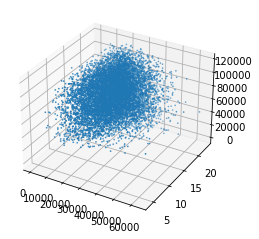

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs = x['km_per_year'], ys = data['model_age'], zs = data['price'], zdir = 'z', s = 0.5)

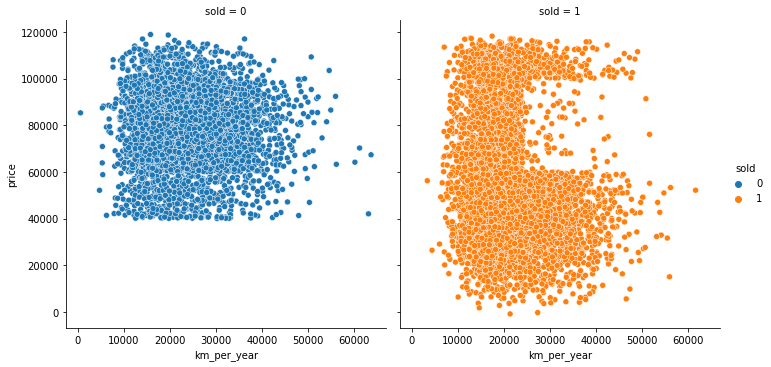

In [8]:
sns.relplot(x = 'km_per_year', y = 'price', hue = y, col = y, data = x)

## Imports Scikit Learn e separação do conjunto de treino e de teste

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

np.random.seed(5)

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size = 0.25,
                                                    #random_state = 5,
                                                    stratify = y)

## Baseline para acurácia do modelo

In [10]:
dummy = DummyClassifier()
dummy.fit(x_train, y_train)
dummy.score(x_test, y_test)

/home/gabriel/.local/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


0.51

## Ajuste do modelo pelo Linear Suport Vector Classifier

In [11]:
model_linear = LinearSVC(max_iter = 5000)
model_linear.fit(x_train, y_train)
prev = model_linear.predict(x_test)

ac_linear = accuracy_score(y_test, prev)
print(ac_linear)

0.58


/home/gabriel/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## Ajuste do modelo pelo Support Vector Classifier

In [12]:
scaler = StandardScaler()
scaler.fit(x_train)
x_test_svc = scaler.transform(x_test)
x_train_svc = scaler.transform(x_train)

model_svc = SVC()
model_svc.fit(x_train_svc, y_train)
prev_svc = model_svc.predict(x_test_svc)

ac_svc = accuracy_score(y_test, prev_svc)
print(ac_svc)

0.7748


## Ajuste de Árvore de Decisão

In [66]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree = DecisionTreeClassifier(max_depth = 3)
tree.fit(x_train, y_train)
prev_tree = tree.predict(x_test)

ac_tree = accuracy_score(y_test, prev_tree)
print(ac_tree)

0.7928


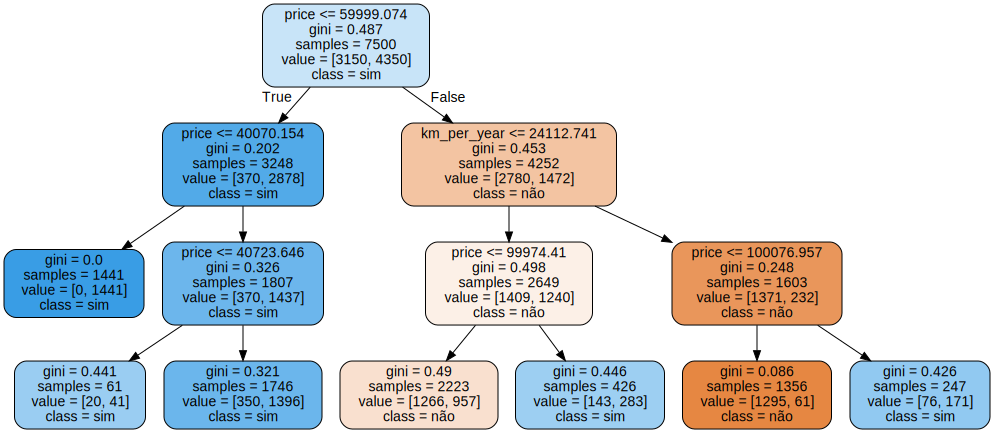

In [67]:
import graphviz

dot_data = export_graphviz(tree, out_file=None,
                           filled = True, rounded = True,
                           feature_names = x.columns,
                           class_names=['não', 'sim'])
graph = graphviz.Source(dot_data)
graph